In [1]:
# tolgo i warning dalle print
import warnings
warnings.filterwarnings("ignore")

In [2]:
# importo il dataset grezzo
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import numpy as np

df_raw = pd.read_csv("UNIPI-IA-dataset.csv")

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xe. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.

In [3]:
# definiamo i tipi in uno specifico ordine. Questo serve perché in caso di duplicati, per esempio:
# https://www.sito-strano.com/haivintounpremio - malware
# https://www.sito-strano.com/haivintounpremio - benign
#
# rimuoveremmo tutti i sample, tranne il primo. Si è deciso questo perché, in questo contesto,
# è preferibile avere un Falso Positivo (FP), manualmente "correggibile" dall'utente, che un Falso Negativo (FN),
# che potrebbe esporrebbe l'utente ad un sito malevolo.

types = ["malware", "phishing", "defacement", "benign"]

df_raw["type"] = pd.Categorical(df_raw["type"], categories=types, ordered=True)
df = df_raw.sort_values(by="type").drop_duplicates(subset="url", keep="first")

print(f"Sample nel Dataset originale: {df_raw.shape[0]}\nSample nel Dataset senza duplicati: {df.shape[0]} (riduzione del {((df_raw.shape[0] - df.shape[0]) / df_raw.shape[0]) * 100:.2f}%)")
print("Distribuzione delle classi nel dataset:")
for type_name in types:
    count = df[df['type'] == type_name].shape[0]
    percentage = (count / df.shape[0]) * 100
    print(f"{type_name}: {count} samples ({percentage:.2f}%)")

Sample nel Dataset originale: 651191
Sample nel Dataset senza duplicati: 641119 (riduzione del 1.55%)
Distribuzione delle classi nel dataset:
malware: 23645 samples (3.69%)
phishing: 94092 samples (14.68%)
defacement: 95308 samples (14.87%)
benign: 428074 samples (66.77%)


In [4]:
# extracting 24 features
from utils.features_extractors import (extract_feature_ip_use,extract_feature_url_entropy,extract_feature_num_digits,extract_feature_url_length,extract_feature_num_query_parameters,extract_feature_num_fragments,extract_feature_num_percent20,extract_feature_num_at_signs,extract_feature_has_http,extract_feature_has_https,extract_feature_dot_number,extract_feature_num_www, extract_feature_directory_num,extract_feature_embed_domain_number,extract_feature_suspiciousurl,extract_feature_count_percent,extract_feature_count_dash,extract_feature_count_equal,extract_feature_is_shortened,extract_feature_hostname_length,extract_feature_first_directory_length,extract_feature_top_level_domain_length,extract_feature_num_letters,extract_feature_num_subdomains)

df['ip_use'] = df['url'].apply(extract_feature_ip_use)
df['url_entropy'] = df['url'].apply(extract_feature_url_entropy)
df['num_digits'] = df['url'].apply(extract_feature_num_digits)
df['url_length'] = df['url'].apply(extract_feature_url_length)
df['num_query_parameters'] = df['url'].apply(extract_feature_num_query_parameters)
df['num_fragments'] = df['url'].apply(extract_feature_num_fragments)
df['num_percent20'] = df['url'].apply(extract_feature_num_percent20)
df['num_at_signs'] = df['url'].apply(extract_feature_num_at_signs)
df['has_http'] = df['url'].apply(extract_feature_has_http)
df['has_https'] = df['url'].apply(extract_feature_has_https)
df['dot_number'] = df['url'].apply(extract_feature_dot_number)
df['num_www'] = df['url'].apply(extract_feature_num_www)
df['directory_num'] = df['url'].apply(extract_feature_directory_num)
df['embed_domain_number'] = df['url'].apply(extract_feature_embed_domain_number)
df['suspiciousurl'] = df['url'].apply(extract_feature_suspiciousurl)
df['count_percent'] = df['url'].apply(extract_feature_count_percent)
df['count_dash'] = df['url'].apply(extract_feature_count_dash)
df['count_equal'] = df['url'].apply(extract_feature_count_equal)
df['is_shortened'] = df['url'].apply(extract_feature_is_shortened)
df['hostname_length'] = df['url'].apply(extract_feature_hostname_length)
df['first_directory_length'] = df['url'].apply(extract_feature_first_directory_length)
df['top_level_domain_length'] = df['url'].apply(extract_feature_top_level_domain_length)
df['num_letters'] = df['url'].apply(extract_feature_num_letters)
df['num_domains'] = df['url'].apply(extract_feature_num_subdomains)

print(f"Total no. of features: { df.drop(columns=['type', 'url']).shape[1] }")

Total no. of features: 24


In [5]:

df = df.drop(columns= ["count_equal", "url_length"])

In [6]:


binary_features = ['ip_use', 'has_http', 'has_https', 'suspiciousurl', 'is_shortened']

numeric_features = [col for col in df.columns if col not in binary_features + ['type', 'url']]

scaler = StandardScaler()
y = df['type']
df_scaled = df.copy()  
df_scaled[numeric_features] = scaler.fit_transform(df[numeric_features])  

X = df_scaled.drop(columns=['type', 'url'])  


X_sampled = X#.sample(n=12000, random_state=42)
y_sampled = y[X_sampled.index]

In [7]:
import numpy as np
from pyclustertend import hopkins
from tqdm import tqdm

X_sampled_array = X_sampled.to_numpy()
sampling_size = int(0.1*len(X_sampled_array))
hopkins_score = hopkins(X_sampled_array, sampling_size)
n_trials = 10
hopkins_scores = []
print("\nComputing multiple Hopkins Statistics...")
for _ in tqdm(range(n_trials)):
    X_subset = X_sampled.sample(n=sampling_size, replace=False).to_numpy()
    hopkins_scores.append(hopkins(X_subset, sampling_size))
avg_hopkins = np.mean(hopkins_scores)
std_hopkins = np.std(hopkins_scores)
print(f"\nHopkins Statistic (media di {n_trials} prove): {avg_hopkins:.3f} ± {std_hopkins:.3f}")



Computing multiple Hopkins Statistics...


100%|██████████| 10/10 [11:54<00:00, 71.42s/it]


Hopkins Statistic (media di 10 prove): 0.004 ± 0.001


Applichiamo ora il DBSCAN, iniziando con min_pts=2*n=44, dove n è il nostro numero di features

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import numpy as np


pca = PCA(n_components=2)
X_sampled_pca = pca.fit_transform(X_sampled)


: 

In [ ]:
from sklearn.metrics import homogeneity_completeness_v_measure, silhouette_score

def apply_dbscan(eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    clusters = dbscan.fit_predict(X_sampled)
    unique_clusters, cluster_counts = np.unique(clusters, return_counts=True)
    
    print(f"DBSCAN con eps={eps} e min_samples={min_samples}")
    print("Number of clusters found:", len(unique_clusters) - 1) 
    print("\nCluster distribution:")
    for cluster, count in zip(unique_clusters, cluster_counts):
        if cluster == -1:
            print(f"Noise points: {count}")
        else:
            print(f"Cluster {cluster}: {count}")
    
    outliers = X_sampled[clusters == -1]
    outlier_percentage = (len(outliers) / len(X_sampled)) * 100  
    print(f"\nPercentage of outliers: {outlier_percentage:.2f}%\n")
    
    try:
        homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y_sampled, clusters)
        
        print(f"Homogeneity: {homogeneity:.3f}")
        print(f"Completeness: {completeness:.3f}")
        print(f"V-Measure: {v_measure:.3f}")

    except NameError:
        print("Le etichette vere 'y_sampled' non sono disponibili. Le metriche Homogeneity, Completeness e V-Measure non possono essere calcolate.")
    except Exception as e:
        print(f"Errore nel calcolo delle metriche: {e}")
    
    clustered_points = X_sampled_pca[clusters != -1]
    cluster_labels = clusters[clusters != -1]
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(clustered_points[:, 0], clustered_points[:, 1],
                          c=cluster_labels, cmap='viridis', s=50)
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'DBSCAN Clustering (eps={eps})/(min_samples={min_samples})')
    plt.colorbar(scatter, label='Cluster')
    plt.text(0.95, 0.01, f'Outliers: {outlier_percentage:.2f}%', 
             verticalalignment='bottom', horizontalalignment='right',
             transform=plt.gca().transAxes,
             color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    
    plt.show()


#apply_dbscan(eps=0.5, min_samples=44)
#apply_dbscan(eps=1, min_samples=44)
#apply_dbscan(eps=3, min_samples=44)
apply_dbscan(eps=6.5, min_samples=44)


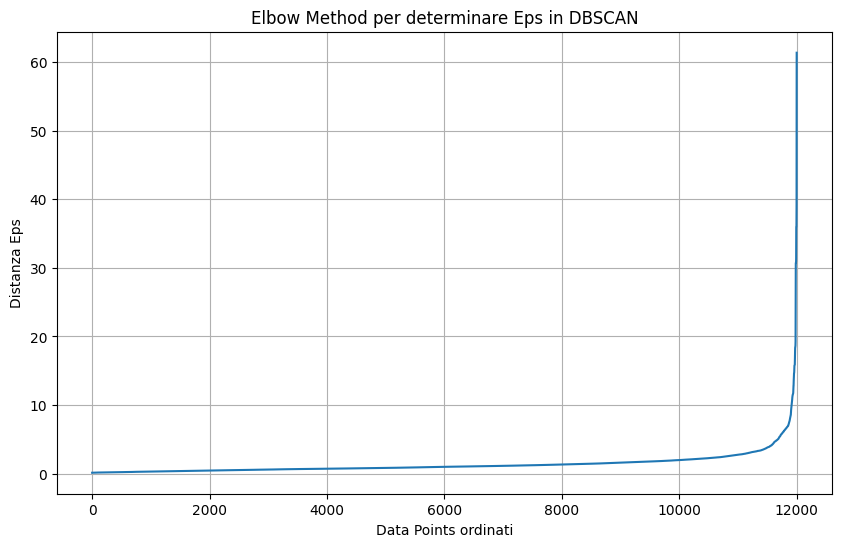

In [10]:
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors


min_samples = 44

neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_sampled_array)
distances, indices = neighbors_fit.kneighbors(X_sampled_array)

distances = np.sort(distances[:, min_samples-1], axis=0)
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Data Points ordinati')
plt.ylabel('Distanza Eps')
plt.title('Elbow Method per determinare Eps in DBSCAN')
plt.grid(True)
plt.show()